#IMPORTANDO BIBLIOTECAS

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow.keras.optimizers import SGD
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import regularizers
from keras.utils.vis_utils import plot_model
from sklearn.utils.multiclass import unique_labels
import seaborn as sn
from google.colab import drive
from keras.applications.vgg16 import decode_predictions
from keras.callbacks import EarlyStopping
import math
from difflib import SequenceMatcher
from scipy.stats import norm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#DEFININDO AS FUNÇÕES DE PRÉ-PROCESSAMENTO

In [ ]:
def get_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if filepath.endswith('.png') or filepath.endswith('.jpg'):
          if cv2.imread(filepath) is not None:
              image = cv2.imread(filepath)
              images.append(image)
    return images

In [ ]:
def PlotHist(img):
  hist, bins = np.histogram(img, bins=256, range=(0, 256))
  hist = hist / np.sum(hist)
  plt.plot(hist)
  plt.show()


In [ ]:
def sort_contours(cnts):
    # compute the bounding box for each contour
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    # sort the bounding boxes by their x-coordinate
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][0], reverse=False))
    # return the sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [ ]:
def resize(img, desired_size):
  old_size = img.shape[:2]
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) if int(x*ratio) != 0 else 1 for x in old_size])
  img = cv2.resize(img, (new_size[1], new_size[0]))

  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
      value=color)
  return new_img

In [ ]:
def add_padding(image, padding_size):
    image = cv2.copyMakeBorder(image, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=0)
    return image


In [ ]:
def resize_and_pad(img, size, padding):
  size = size - 2 * padding
  resized = resize(img, size)
  aux = add_padding(resized, padding)
  return aux

In [ ]:
def segment_image(image):
  img = image
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU )
  thresh = cv2.bitwise_not(thresh)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  dilated_image = cv2.dilate(thresh, kernel)
  median = cv2.medianBlur(dilated_image,9)
  blurred = cv2.GaussianBlur(median, (5, 5), 0)
  contours, hierarchy = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  (contours, boundingBoxes) = sort_contours(contours)
  segmented_images = []
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    symbol = median[y:y+h, x:x+w]
    segmented_images.append(symbol)
  for i in range(len(segmented_images)):
    if segmented_images[i].shape[0] * segmented_images[i].shape[1] <= 1000 and segmented_images[i].shape[1] / segmented_images[i].shape[0] < 2.5:
      segmented_images[i] = resize_and_pad(segmented_images[i], 28, 12)
    else:
      segmented_images[i] = resize_and_pad(segmented_images[i], 28, 4)
  segmented_images = np.expand_dims(segmented_images, -1)
  return segmented_images



#PASSO A PASSO COM UM EXEMPLO

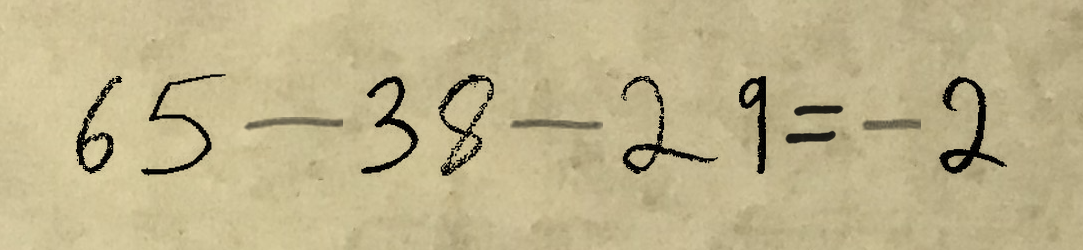

In [ ]:
# Carregar a imagem
img = cv2.imread('/content/drive/MyDrive/expressoes/img/Math0_20230110032351.png')
cv2_imshow(img)

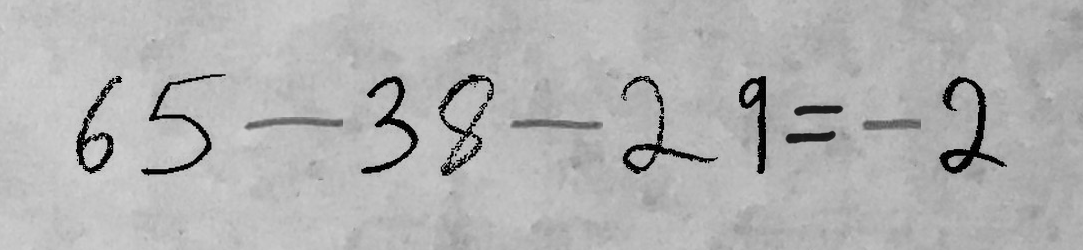

In [ ]:
# Converter a imagem para tons de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

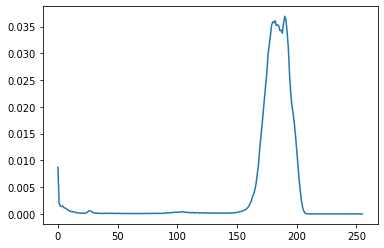

In [ ]:
PlotHist(gray)

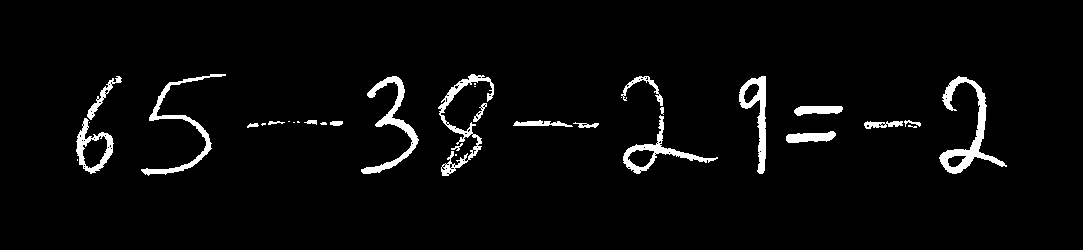

In [ ]:
#BINARIZAÇÃO DA IMAGEM

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
thresh = cv2.bitwise_not(thresh)
cv2_imshow(thresh)

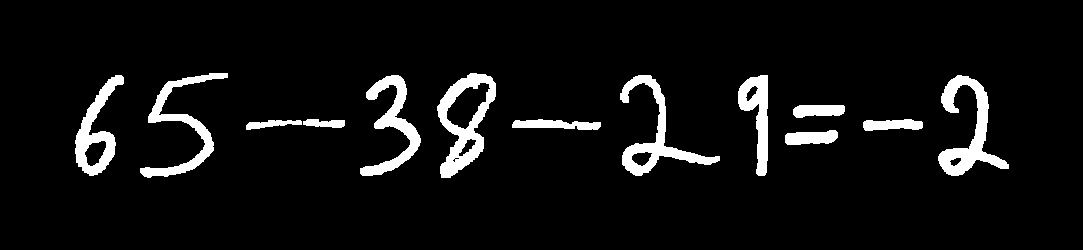

In [ ]:
# Dilatando a imagem

# Create a kernel with a specific shape
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

# Dilate the image
dilated_image = cv2.dilate(thresh, kernel)

cv2_imshow(dilated_image)

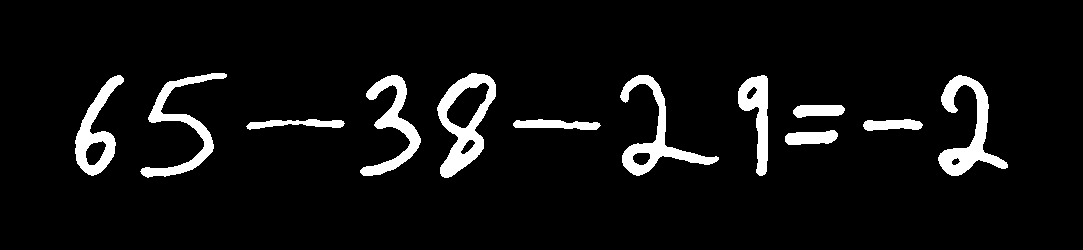

In [ ]:
#PASSA-BAIXA DE MEDIANA

median = cv2.medianBlur(dilated_image, 7)
cv2_imshow(median)

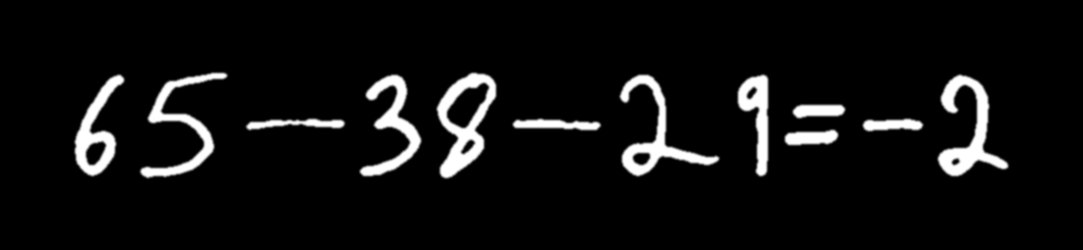

In [ ]:
#PASSA-BAIXA GAUSSIANO

blurred = cv2.GaussianBlur(median, (5, 5), 0)
cv2_imshow(blurred)

In [ ]:
# Encontrar os contornos da imagem
contours, hierarchy = cv2.findContours(blurred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
(contours, boundingBoxes) = sort_contours(contours)

segmented_images = []
# Loop pelos contornos encontrados
for cnt in contours:
  # Obter o retângulo que envolve o contorno
  x, y, w, h = cv2.boundingRect(cnt)

  # Extrair o símbolo do contorno
  symbol = median[y:y+h, x:x+w]

  # Salvar o símbolo em um arquivo
  segmented_images.append(symbol)

In [ ]:
aux = []
for i in range(len(segmented_images)):
  aux.append(segmented_images[i].shape[0] * segmented_images[i].shape[1])

<BarContainer object of 12 artists>

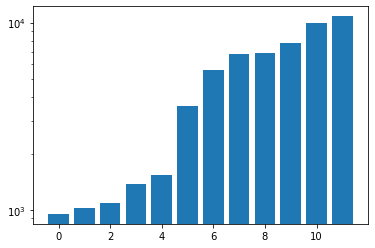

In [ ]:
aux.sort()
plt.yscale('log')
plt.bar(list(range(len(aux))), aux)


In [ ]:
cv2_imshow(resize_and_pad(segmented_images[3], 28, 12))

#IMPORTANDO OS DADOS DO CONJUNTO MNIST

In [ ]:
# Model / data parameters
num_classes = 14
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(X_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

X = np.concatenate((X_train, x_test))
X = X.astype('float32') / 255
X = np.expand_dims(X, -1)

print("X shape:", X.shape)

# convert class vectors to binary class matrices
Y = np.concatenate((y_train, y_test))
Y = keras.utils.to_categorical(Y, num_classes)

X shape: (70000, 28, 28, 1)


#IMPORTANDO OS DEMAIS DADOS UTILIZADOS NO TREINO

In [ ]:
def rotate_image(image):
    image = cv2.resize(image, (image.shape[0], image.shape[0]))
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
    rotated_image_90 = cv2.warpAffine(image, M, (cols, rows))
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 180, 1)
    rotated_image_180 = cv2.warpAffine(image, M, (cols, rows))
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 270, 1)
    rotated_image_270 = cv2.warpAffine(image, M, (cols, rows))
    return image, rotated_image_90, rotated_image_180, rotated_image_270

In [ ]:
add = get_images_from_folder('/content/drive/MyDrive/expressoes/add')
mul = get_images_from_folder('/content/drive/MyDrive/expressoes/mul')
sub = get_images_from_folder('/content/drive/MyDrive/expressoes/sub')
dot = get_images_from_folder('/content/drive/MyDrive/expressoes/dot')

a divisão nao será utilizada no treino pois ela será calculada de outra forma

In [ ]:
operacoes = [add, mul, sub, dot]

Pré processando as imagens e formatando no padrão do MNIST

In [ ]:
def image_to_mnist(img):
  if img.shape[-1] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
  ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
  img = cv2.bitwise_not(thresh)
  img = cv2.GaussianBlur(img, (5, 5), 0)
  img = cv2.resize(img, (20, 20))
  img = cv2.copyMakeBorder(img, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)
  return img

In [ ]:
for i in range(len(operacoes)):
  for j in range(len(operacoes[i])):
    aux = image_to_mnist(operacoes[i][j])
    aux = aux / 255
    aux = cv2.resize(aux, (28, 28))
    aux = np.expand_dims(aux, -1)
    operacoes[i][j] = aux

In [ ]:
y_add = [np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype='float32') for i in range(len(operacoes[0]))]
y_mul = [np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype='float32') for i in range(len(operacoes[1]))]
y_sub = [np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype='float32') for i in range(len(operacoes[2]))]
y_dot = [np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype='float32') for i in range(len(operacoes[3]))]

In [ ]:
for i in range(1):
  X = np.concatenate((X, np.array(operacoes[0])))
  X = np.concatenate((X, np.array(operacoes[1])))
  X = np.concatenate((X, np.array(operacoes[2])))
  X = np.concatenate((X, np.array(operacoes[3])))

In [ ]:
for i in range(1):
  Y = np.concatenate((Y, np.array(y_add)))
  Y = np.concatenate((Y, np.array(y_mul)))
  Y = np.concatenate((Y, np.array(y_sub)))
  Y = np.concatenate((Y, np.array(y_dot)))

In [ ]:
print(X.shape, Y.shape)

(72452, 28, 28, 1) (72452, 14)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
cv2_imshow(operacoes[-2][4]* 255)

#TREINO DA REDE NEURAL

In [ ]:
def train(momentum=0, epochs=20, batch_size=32, model=None):
  if model is None:
    model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Dropout(0.3),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Dropout(0.3),
          layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
          layers.Flatten(),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.3),
          layers.Dense(num_classes, activation="softmax"),
      ]
  )
  plot_model(model, to_file='modelo2.png', show_shapes=True, show_dtype=True, show_layer_names=False)
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

  fig, ax = plt.subplots(1,2, figsize=(16,8))
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

  print(history.history['val_accuracy'][-1])
  return model, history

Epoch 1/100
1631/1631 [==============================] - 14s 8ms/step - loss: 0.3275 - accuracy: 0.8973 - val_loss: 0.0701 - val_accuracy: 0.9787
Epoch 2/100
1631/1631 [==============================] - 7s 5ms/step - loss: 0.1085 - accuracy: 0.9672 - val_loss: 0.0510 - val_accuracy: 0.9855
Epoch 3/100
1631/1631 [==============================] - 8s 5ms/step - loss: 0.0809 - accuracy: 0.9759 - val_loss: 0.0411 - val_accuracy: 0.9874
Epoch 4/100
1631/1631 [==============================] - 7s 5ms/step - loss: 0.0661 - accuracy: 0.9801 - val_loss: 0.0376 - val_accuracy: 0.9894
Epoch 5/100
1631/1631 [==============================] - 8s 5ms/step - loss: 0.0593 - accuracy: 0.9822 - val_loss: 0.0349 - val_accuracy: 0.9893
Epoch 6/100
1631/1631 [==============================] - 8s 5ms/step - loss: 0.0515 - accuracy: 0.9846 - val_loss: 0.0320 - val_accuracy: 0.9915
Epoch 7/100
1631/1631 [==============================] - 8s 5ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0337 - val_a

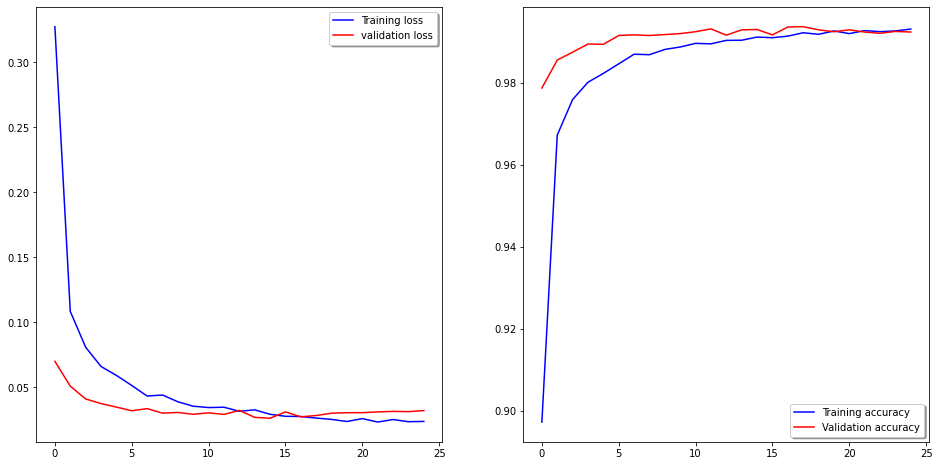

In [ ]:
model, history = train(epochs=100)

In [ ]:
#history = model.fit(X_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

In [ ]:
#model.save('/content/drive/MyDrive/expressoes/models/model2')

treinando o modelo no conjunto de dados só do ponto

#RESULTADOS DO CONJUNTO DE TESTE

In [ ]:
result = model.predict(X_test)

227/227 [==============================] - 0s 2ms/step


In [ ]:
def predict(probs):
  max_index = probs.argmax()
  predictions = [0] * len(probs)
  predictions[max_index] = 1
  return predictions


In [ ]:
def score():
  counter = 0
  for i in range(len(result)):
    counter += 1 if result[i] == y_test[i] else 0
  return counter / len(result)

In [ ]:
result = [predict(x).index(1) for x in result]

In [ ]:
y_test = [list(x).index(1) for x in list(y_test)]

In [ ]:
print(score())

0.9914435550648634


#PEGANDO UMA IMAGEM E OBTENDO OS CARACTERS

In [ ]:
image = cv2.imread('/content/drive/MyDrive/expressoes/img/Math20_20230110032400.png')
result = np.array(segment_image(image))

In [ ]:
for i in result:
  cv2_imshow(i)

In [ ]:
prediction = model.predict(result  / 255)

1/1 [==============================] - 0s 18ms/step


In [ ]:
prediction = [predict(x).index(1) for x in prediction]

In [ ]:
for i in range(len(prediction)):
  if prediction[i] == 10:
    prediction[i] = "+"
  elif prediction[i] == 11:
    prediction[i] = "x"
  elif prediction[i] == 12:
    prediction[i] = "-"
  elif prediction[i] == 13:
    prediction[i] = '.'

In [ ]:
def list_to_string(input_list):
    return ''.join(str(i) for i in input_list)

In [ ]:
def read_txt(file):
  file_address = '/content/drive/MyDrive/expressoes/txt/' + file
  with open(file_address, 'r') as f:
    line = f.readline()
    f.close()
  return line.replace(' ', '').replace('\\times', 'x').replace('\\div', '/')

In [ ]:
def syntax_analysis(equation):
   equation = equation.replace('..-', '/')
   equation = equation.replace('-..', '/')
   equation = equation.replace('.-.', '/')
   equation = equation.replace("--", "=")
   equation = equation.replace('.-.', '/')
   return equation

In [ ]:
read_txt('Math20_20230110032400.txt')

'82+67+50=199'

In [ ]:
list_to_string(prediction)

'82+67+50--179'

In [ ]:
print(syntax_analysis(list_to_string(prediction)))

82+67+50=179


In [ ]:
def predict_equation(img):
  image = cv2.imread('/content/drive/MyDrive/expressoes/img/'+img)
  if image is None:
      print(f'{img} not found or invalid')
      return
  result = np.array(segment_image(image))
  prediction = model.predict(result  / 255, verbose=0)
  prediction = [predict(x).index(1) for x in prediction]
  for i in range(len(prediction)):
      if prediction[i] == 10:
          prediction[i] = "+"
      elif prediction[i] == 11:
          prediction[i] = "x"
      elif prediction[i] == 12:
          prediction[i] = "-"
      elif prediction[i] == 13:
          prediction[i] = '.'
  original_txt = read_txt(img.replace('png', 'txt'))
  
  return original_txt, syntax_analysis(list_to_string(prediction))

In [ ]:
predict_equation('Math6_20230110032354.png')

('79x58-97=4485', '.-79.x58=-97=.-4...4.85.-/')

#REALIZANDO TESTES

In [ ]:
predictions = []

In [ ]:
path = '/content/drive/MyDrive/expressoes/img/'

for file in os.listdir(path):
    if file.endswith('.png'):
        img = file
        original_txt, predicted_txt = predict_equation(img)
        predictions.append((original_txt, predicted_txt))

In [ ]:
def check_similarity(str1, str2):
    similarity = SequenceMatcher(None, str1, str2).ratio()
    return similarity

In [ ]:
score = 0
for i in predictions:
  score += 1 if i[0] == i[1] else 0
print(score / len(predictions) * 100)

20.8


In [ ]:
similarity = []
for i in predictions:
  similarity.append(check_similarity(i[0], i[1]))
similarity = np.array(similarity)

0.8443571405528989
0.1450074334229273


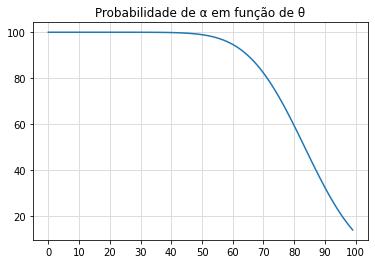

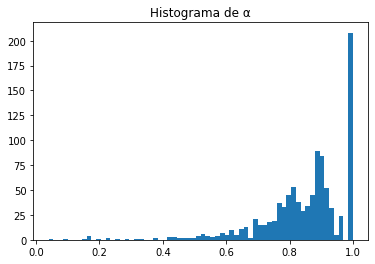

In [ ]:
print(similarity.mean())
print(similarity.std())

mean = similarity.mean()
std_dev = similarity.std()
limiar = 0.8

aux = []
for i in range(100): 
  prob = 1 - norm.cdf((i+1) / 100, mean, std_dev)
  aux.append(prob * 100)

plt.plot(aux)
plt.grid(color='#dddddd', linestyle='-', linewidth=1)
plt.xticks(np.arange(0, 101, 10.0))
plt.title('Probabilidade de α em função de θ')
plt.show()

plt.hist(similarity, bins=64)
plt.title('Histograma de α')
plt.show()

In [ ]:
score = 0
for i in similarity:
  score += 1 if i == 1 else 0
print(score)

208


In [ ]:
predictions[0][0]

'65-38-29=-2'

In [ ]:
def format_string(s):
    aux1, aux2 =  ' '.join(s.replace('-', ' - ').replace('=', ' = ').replace('x', ' x ').replace('/', ' / ').replace('+', ' + ').split()).split('=')
    aux2 = aux2.replace(' ', '')
    return aux1, aux2

In [ ]:
import operator
operators = {
    '+': operator.add,
    '-': operator.sub,
    'x': operator.mul,
    '/': operator.truediv,
}

precedence = {
    '+': 1,
    '-': 1,
    'x': 2,
    '/': 2,
}

def evaluate(expression):
    tokens = expression.split()
    values = []
    ops = []
    for token in tokens:
        if token in operators:
            while ops and ops[-1] in operators and precedence[ops[-1]] >= precedence[token]:
                op2, op1 = values.pop(), values.pop()
                result = operators[ops.pop()](op1, op2)
                values.append(result)
            ops.append(token)
        else:
            values.append(float(token))
    while ops:
        op2, op1 = values.pop(), values.pop()
        result = operators[ops.pop()](op1, op2)
        values.append(result)
    return values[0]
